## Imports

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gianc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gianc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import time
import datetime

In [3]:
# Beep when notebook stops running code
import winsound
def beep(reps=1, duration=500, freq=440, sleep=1):
    for _ in range(reps - 1):
        winsound.Beep(freq, duration)
        time.sleep(sleep)
    winsound.Beep(freq, duration)

## Data

Load the cleaned reviews:

In [4]:
%%time
data = "dataset/AmazonCellReviewsPreprocessed.csv"
df = pd.read_csv(data)
df = df[df.reviewText.notna()]
df.head()

Wall time: 5.99 s


,reviewText,reviewTextPreprocessed,overall,verified
0,Looks even better in person. Be careful to not...,looks even better in person be careful to not ...,5,True
1,When you don't want to spend a whole lot of ca...,when you do not want to spend a whole lot of c...,5,True
2,"so the case came on time, i love the design. I...",so the case came on time i love the design im ...,3,True
3,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,do not care for it gave it as a gift and they...,2,True
4,"I liked it because it was cute, but the studs ...",i liked it because it was cute but the studs f...,4,True


In [5]:
df.shape

(1127630, 4)

See proportion of positive ($>3$) and critical ($\leq 3$) reviews:

In [6]:
df["positive"] = df.overall > 3

In [7]:
df.groupby("positive").size()

positive
False    236880
True     890750
dtype: int64

In [8]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.210069
True     0.789931
dtype: float64

The class to predict is highly unbalanced. We can sample in order to have a balanced class:

In [9]:
sample_size = 200000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [10]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [11]:
sample_df.groupby("positive").size()

positive
False    200000
True     200000
dtype: int64

#### Choice: Unbalanced or Balanced Classes

Definition of unbalanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on the reviews from the Amazon dataset.

In [12]:
# X = df.reviewTextPreprocessed.values
# y = df.positive.values

Definition of balanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset).

In [12]:
X = sample_df.reviewTextPreprocessed.values
y = sample_df.positive.values

## Order of operations from now on:

First of all, we define a list of stopwords.

The next step is the preprocessing needed to obtain a suitable representation of the reviews, which are:

- Tokenization
- Spelling correction
- Stop words removal
- Stemming

After these operations, the reviews are going to be passed to a vectorizer in order to obtain the final representation for the classifiers.

Stemming can be achieved using two different libraries: NLTK and PyStemmer. PyStemmer is faster, but needs Visual C++ Build Tools installed. Please choose the relevant code you prefer to run.

#### Rough execution times:

(Execution times might be different from the following, I ran the notebook again afterwards)

#### NLTK

- Tokenization, 3min 15s
- Spell check and correction, 14min 11s (`proprocessor` parameter)
- Stop words removal, 1min 6s (`stop_words` parameter)
- Stemming, 7min 10s (Porter) 5min 56s (Lancaster)
- Vectorization, 58.8 s (Porter), 56.6 s(Lancaster)

#### PyStemmer

Class that performs

- Tokenization
- Spell check and correction (parameter `preprocessor`)
- Stop words removal (parameter `stop_words`)
- Stemming (with `pystemmer`)
- Vectorization

8min 49s

### Definition of the list of Stop-words

In [13]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews. We define the  dictionaries needed for the preprocessing, as in the previous notebook:

In [14]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ",  r":[- ]?\)+": " good ", r";-?\)+": " good ",
    r"\(+-?:": " good ", r"=\)+" : " good ", r"<3" : " good ",
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", r":\\+": " bad ", r"[\s\r\t\n]+\)-?:": " bad ",
    r":-?\(+": " bad ", r"[\s\t\r\n]+d+-?:": " bad "
}

contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not", r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not", r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not", r"n\'": " not", r"\'s": " is", r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", r"\'d": " would",
}

with open('slang_subset_manual.json', 'r') as fid:
    slang_repl = json.load(fid)

Same preprocessing function as in the previous notebook:

In [15]:
def preprocess(sent, translate_slang = True):
    
    sent = sent.lower()
    sent = re.sub(r'^<div id="video.*>&nbsp;', '', sent) # Video-review part
    sent = re.sub('https?://[A-Za-z0-9./]+', '', sent) # URLs
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[/]+', ' ', sent) # word1/word2 to word1 word2
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    sent = re.sub('\b\d+\b', '', sent)
    
    return sent

In [16]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [17]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [18]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words:

In [19]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [20]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

## Tokenization/Spell Correction/StopWordsRemoval/Stemming

### NLTK

In [49]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [50]:
%%time
X_tokenized = tokenize_reviews(X)

Wall time: 3min 50s


Spelling correction:

In [51]:
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [52]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

Wall time: 23min 24s


Stop words removal:

In [53]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

Wall time: 1min 1s


In [54]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [55]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [56]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

Wall time: 8min


In [57]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

Wall time: 6min 43s


### PyStemmer (needs Visual C++ installed)

Definition of the class StemmedTdidfVectorized.

- `sklearn`'s `TfidfVectorizer` takes care of tokenization, stop-word removal, vectorization
- `pystemmer` takes care of stemming.

In [21]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

In [22]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [23]:
from sklearn.model_selection import train_test_split

#### NLTK

Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation.

In [59]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

#### Pystemmer

Here we are train/test splitting the preprocessed set of reviews to be passed to `StemmedTfidfVectorizer` for tokenization+stemming+representation.

In [24]:
X_train_pystemmer, X_test_pystemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

## Text Representation

#### NLTK

In [60]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [61]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [62]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

Wall time: 1min 1s


In [63]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

Wall time: 1min


#### Pystemmer

In [34]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_pystemmer = StemmedTfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_pystemmer = tfidf_vect_pystemmer.fit_transform(X_train_pystemmer)
X_test_tfidf_pystemmer = tfidf_vect_pystemmer.transform(X_test_pystemmer)

Wall time: 2min 49s


In [49]:
# dump(tfidf_vect_pystemmer, 'joblib_data/tfidf_vect_pystemmer.joblib') 

['tfidf_vect_pystemmer.joblib']

In [35]:
beep()

####  No stemming

In [36]:
X_train_nostemmer, X_test_nostemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

In [37]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_nostemmer = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_nostemmer = tfidf_vect_nostemmer.fit_transform(X_train_nostemmer)
X_test_tfidf_nostemmer = tfidf_vect_nostemmer.transform(X_test_nostemmer)

Wall time: 2min 9s


In [47]:
# dump(tfidf_vect_nostemmer, 'joblib_data/tfidf_vect_nostemmer.joblib') 

['tfidf_vect_nostemmer.joblib']

In [48]:
beep()

# Classification

## NB Classifier

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Accessory functions:

In [40]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [41]:
def score_NB(clf, X_train, X_test, y_train, y_test):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    
    proba = clf.predict_proba(X_test)

    precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
    
    auc_score = auc(recall, precision)
    
    scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                      "Test Recall", "F1", "F2", "P/R AUC"]
    
    scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
    
    print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))
    
    print(classification_report(y_test,predictions))
    
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
    plt.legend(loc="lower left")
    plt.show()

###  No Stemmer

In [42]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_nostemmer, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
print_top_features(tfidf_vect_nostemmer, clf, 50)

Most discriminative features:
 great, good, case, love, phone, very, works, not, product, excellent, nice, perfect, well, like, screen, one, fits, works great, price, easy, quality, great product, fit, use, very good, really, iphone, perfectly, protector, awesome, protection, recommend, looks, charger, time, best, charge, get, little, bought, buy, fast, battery, ok, great case, screen protector, much, work, still, thanks


Train Accuracy       0.86926
Test Accuracy        0.85705
Test Precision       0.86211
Test Recall          0.84936
F1                   0.85569
F2                   0.85188
P/R AUC              0.92931
              precision    recall  f1-score   support

       False       0.85      0.86      0.86     66135
        True       0.86      0.85      0.86     65865

    accuracy                           0.86    132000
   macro avg       0.86      0.86      0.86    132000
weighted avg       0.86      0.86      0.86    132000



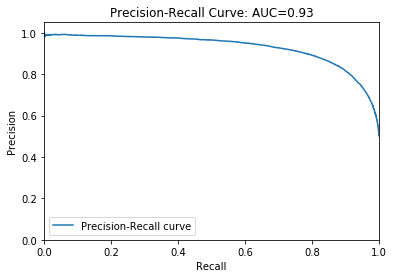

In [44]:
score_NB(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)

In [50]:
beep()

In [51]:
# dump(clf, 'joblib_data/clf_nb_nostemmer.joblib') 

['clf_nb_nostemmer.joblib']

### NLTK

#### Porter

In [67]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [68]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, case, phone, love, work, not, veri, product, nice, excel, fit, like, perfect, use, well, protect, charg, screen, one, work great, look, price, easi, protector, qualiti, thank, great product, time, realli, get, veri good, recommend, need, perfectli, charger, screen protector, buy, awesom, batteri, bought, color, feel, cabl, expect, best, littl, cover, ok, fast


Train Accuracy       0.88750
Test Accuracy        0.88193
Test Precision       0.89418
Test Recall          0.96467
F1                   0.92809
F2                   0.94970
P/R AUC              0.97673
             precision    recall  f1-score   support

      False       0.81      0.57      0.67     78224
       True       0.89      0.96      0.93    293908

avg / total       0.88      0.88      0.87    372132



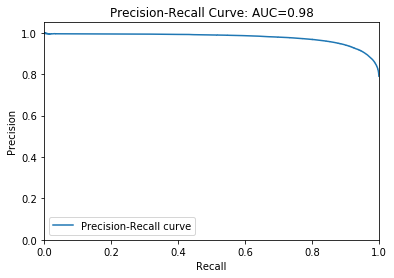

In [69]:
score_NB(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

#### Lancaster

In [70]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [71]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, cas, phon, lov, work, not, excel, very, produc, protect, perfect, nic, charg, fit, lik, us, wel, on, screen, work gre, look, easy, pric, qual, thank, gre produc, real, tim, get, very good, recommend, screen protect, nee, buy, awesom, battery, bought, fast, col, feel, cabl, expect, cov, hold, best, littl, ok, ev, purchas


Train Accuracy       0.88586
Test Accuracy        0.88008
Test Precision       0.89178
Test Recall          0.96530
F1                   0.92709
F2                   0.94964
P/R AUC              0.97633
             precision    recall  f1-score   support

      False       0.81      0.56      0.66     78224
       True       0.89      0.97      0.93    293908

avg / total       0.87      0.88      0.87    372132



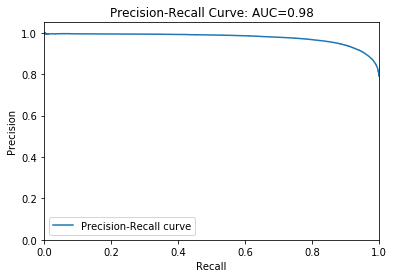

In [72]:
score_NB(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

###  PyStemmer

In [52]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_pystemmer, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
print_top_features(tfidf_vect_pystemmer, clf, 50)

Most discriminative features:
 great, good, love, case, phone, work, veri, product, perfect, not, nice, excel, fit, like, well, use, protect, charg, one, screen, look, works great, price, easi, thank, qualiti, great product, protector, time, very good, iphon, realli, recommend, get, need, charger, awesom, screen protector, buy, batteri, color, cabl, best, feel, expect, bought, littl, fast, ok, purchas


Train Accuracy       0.86850
Test Accuracy        0.85619
Test Precision       0.86114
Test Recall          0.84863
F1                   0.85484
F2                   0.85110
P/R AUC              0.92835
              precision    recall  f1-score   support

       False       0.85      0.86      0.86     66135
        True       0.86      0.85      0.85     65865

    accuracy                           0.86    132000
   macro avg       0.86      0.86      0.86    132000
weighted avg       0.86      0.86      0.86    132000



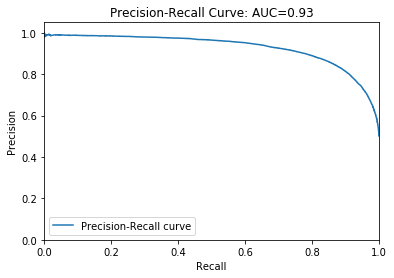

In [54]:
score_NB(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)

In [56]:
# dump(clf, 'joblib_data/clf_nb_pystemmer.joblib') 

['clf_nb_pystemmer.joblib']

## Random forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

### Porter

In [74]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_Porter, y_train) # it takes around 30 minutes

building tree 1 of 50
building tree 2 of 50building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 40.3min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 57.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [75]:
train_score = clf.score(X_train_tfidf_Porter, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_Porter, y_test)    # Test Accuracy

predictions = clf.predict(X_test_tfidf_Porter)

print(classification_report(y_test,predictions))

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.6s


             precision    recall  f1-score   support

      False       0.85      0.56      0.68     78224
       True       0.89      0.97      0.93    293908

avg / total       0.89      0.89      0.88    372132



[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.0s finished


Results are more encouraging! The problem is that it's way slower than Multinomial NB.

## TruncatedSVD
The X_train vector has around 20k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

In [76]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_Porter_svd = tsvd.fit_transform(X_train_tfidf_Porter)
X_test_tfidf_Porter_svd = tsvd.transform(X_test_tfidf_Porter)

Wall time: 4min 35s


In [77]:
print("train with old features: ",np.array(X_train_tfidf_Porter).shape)
print("train with new features:" ,np.array(X_train_tfidf_Porter_svd).shape)

train with old features:  ()
train with new features: (755540, 500)


#### Store SVD-transformed dataset

In [78]:
# dump(X_train_tfidf_Porter_svd, 'joblib_data/X_train_tfidf_Porter_svd.joblib')
# dump(X_test_tfidf_Porter_svd, 'joblib_data/X_test_tfidf_Porter_svd.joblib')

['X_test_tfidf_Porter_svd.joblib']

### Random Forest

In [79]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_Porter_svd, y_train)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.5min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [80]:
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.6s


             precision    recall  f1-score   support

      False       0.83      0.42      0.56     78224
       True       0.86      0.98      0.92    293908

avg / total       0.86      0.86      0.84    372132



[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished


## SVM
### LinearSVC

In [81]:
from sklearn import svm

In [86]:
clf = svm.LinearSVC(random_state=42)

In [87]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 6min 27s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [88]:
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.79      0.57      0.67     78224
       True       0.89      0.96      0.93    293908

avg / total       0.87      0.88      0.87    372132



## SVC

In [89]:
clf = svm.SVC(random_state=42, max_iter=500)

In [92]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 7min 29s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [93]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.28      0.59      0.38     78224
       True       0.85      0.59      0.70    293908

avg / total       0.73      0.59      0.63    372132

Wall time: 3min 18s


## Adaboost
### 10 estimators

In [94]:
from sklearn.ensemble import AdaBoostClassifier

In [97]:
%%time
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 10min


In [98]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.61      0.37      0.46     78224
       True       0.85      0.94      0.89    293908

avg / total       0.80      0.82      0.80    372132

Wall time: 2.2 s


### 15 estimators

In [99]:
%%time
clf = AdaBoostClassifier(n_estimators=15, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 14min 57s


In [100]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.63      0.35      0.45     78224
       True       0.85      0.94      0.89    293908

avg / total       0.80      0.82      0.80    372132

Wall time: 2.97 s


Increasing the number of estimators did not lead to an improvement in performances: let's see what happens when we reduce them.
## 5 estimators

In [101]:
%%time
clf = AdaBoostClassifier(n_estimators=5, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 5min 1s


In [102]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      False       0.59      0.26      0.36     78224
       True       0.83      0.95      0.89    293908

avg / total       0.78      0.81      0.78    372132

Wall time: 1.45 s


Performances are a bit worse

# TODO

- Add *short* examples after some steps.
- Decide what to do with slang. Probably very necessary for preprocessing tweets. If we want to use it for the Amazon dataset, we might reduce the size of the dict by checking which terms are actually present in the reviews, and only keep the ones that are present in many reviews.
- Tweets part